In [1]:
import pickle
import os
import math
import matplotlib.pyplot as plt
from statsmodels.formula.api import poisson
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd

TWITTER_DATA_DIR = '/home/jschless/whatsapp/data/twitter-coordination-src/data'
DATA_DIR = '/pool001/jschless/kiran-data/kiran-data/'


## Dataset Quick Stats

In [ ]:
with open(os.path.join(TWITTER_DATA_DIR, 'campaign_tweets.pkl'), 'rb') as f:
    temp = pickle.load(f)
df = pd.DataFrame.from_dict([
    {'hashtag': hashtag, **item} for hashtag, sublist in temp.items() for item in sublist.values()])

In [ ]:
df = pd.DataFrame.from_dict([
    {'hashtag': hashtag, **item} for hashtag, sublist in temp.items() for item in sublist.values()])
df.head()

In [ ]:
len(df.hashtag.unique())

In [ ]:
len(df)

In [ ]:
df.groupby('hashtag').count().describe()

In [ ]:
len(df.username.unique())

# Main Analysis

In [ ]:
with open(os.path.join(TWITTER_DATA_DIR, 'panel_df_dict.pkl'), 'rb') as f:
    df_dict = pickle.load(f)

In [ ]:
top_10_panel_df = df_dict[('earliest', 10)]
top_50_panel_df = df_dict[('earliest', 50)]

In [4]:
def plot_event_study(df, cat: str='zero_exposure_tweets', quantiles=(.025,.975),
                    lower=-120, upper=120, title=None, include_errors=False,
                    adjust_time=None, create_donut_hole=False, color='#1f77b4'):
    
    if title is None:
        title = cat
    df = df.loc[(df.index>lower)&(df.index<upper)]
    median = df.groupby('time')[cat].median()
    mean = df.groupby('time')[cat].mean()
    p025 = df.groupby('time')[cat].quantile(quantiles[0])
    p975 = df.groupby('time')[cat].quantile(quantiles[1])
    
    if adjust_time:
        # adjusting 5 minutes for the 5 minute uncertainty window
        # adjust another 5 minutes for 5 minute binning window.
        mean.index = mean.index.map(lambda x: x+adjust_time)

    if create_donut_hole:
        mean = mean.loc[(mean.index < 0) | (mean.index > 60)]
    if include_errors:
        plt.errorbar(mean.index, mean, xerr=.5, yerr=[mean-p025, p975-mean],
                     fmt='o', capsize=10, label='mean')
    else:
        plt.scatter(mean.index, mean, c=color)
        plt.plot(mean.index, mean, c=color)

    plt.title('Unexposed New Tweets Event Study' )
    plt.xlabel('Time')

    plt.ylabel('Tweet Volume')

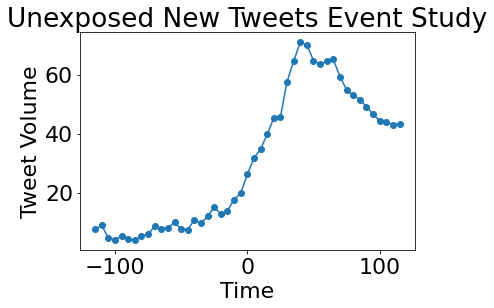

In [91]:
plot_event_study(top_50_panel_df, cat='total_engagement')

In [61]:
top_50_panel_df['all_tweets'] = top_50_panel_df['template'] + top_50_panel_df['regular']

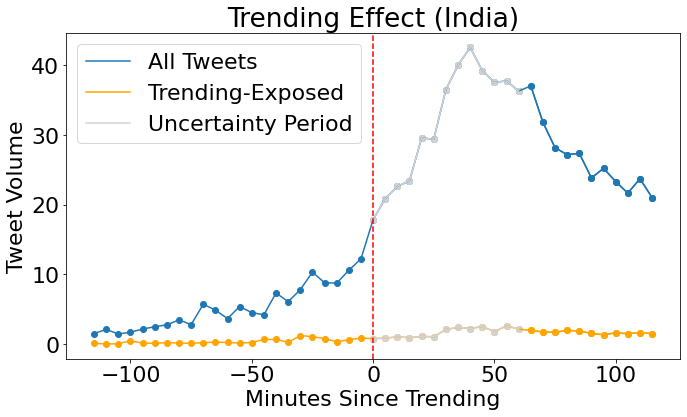

In [77]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
FIG_DIR = '/home/jschless/paper_figs'

plt.figure(figsize=(11,6))
CAT = 'all_tweets'
# plot_event_study(top_50_panel_df.loc[top_50_panel_df.index<0], cat='zero_exposure_regular', create_donut_hole=False)
plot_event_study(top_50_panel_df, cat=CAT, create_donut_hole=False)
plot_event_study(top_50_panel_df.loc[(top_50_panel_df.index<=60) & (top_50_panel_df.index>=0)], 
                 cat=CAT, create_donut_hole=False, color='lightgrey')
plot_event_study(top_50_panel_df.loc[top_50_panel_df.index>60], cat=CAT, create_donut_hole=False)


# CAT = 'nonzero_exposure_regular'
# # plot_event_study(top_50_panel_df.loc[top_50_panel_df.index<0], cat='zero_exposure_regular', create_donut_hole=False)
# plot_event_study(top_50_panel_df, cat=CAT, create_donut_hole=False, color='orange')
# plot_event_study(top_50_panel_df.loc[(top_50_panel_df.index<60) & (top_50_panel_df.index>0)], 
#                  cat=CAT, create_donut_hole=False, color='lightgrey')
# plot_event_study(top_50_panel_df.loc[top_50_panel_df.index>60], cat=CAT, create_donut_hole=False)
CAT = 'zero_exposure_regular'
plot_event_study(top_50_panel_df, cat=CAT, create_donut_hole=False, color='orange')
plot_event_study(top_50_panel_df.loc[top_50_panel_df.index>60], cat=CAT, create_donut_hole=False, color='orange')
plot_event_study(top_50_panel_df.loc[(top_50_panel_df.index<=60) & (top_50_panel_df.index>=0)], 
                 cat=CAT, create_donut_hole=False, color='lightgrey')

# making a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#1f77b4', label='All Tweets'),
                   Line2D([0], [0], color='orange', label='Trending-Exposed'),
                   Line2D([0], [0], color='lightgrey', label='Uncertainty Period')
]

plt.legend(handles=legend_elements, loc='upper left')
plt.title('Trending Effect (India)')
plt.xlabel('Minutes Since Trending')
plt.axvline(x=0, c='r', ls='--')
plt.savefig(os.path.join(FIG_DIR, 'india_event_study_donut_hole_2.pdf'), bbox_inches="tight")

In [78]:
def plot_event_study_2(df, ax, cat: str='zero_exposure_tweets', quantiles=(.025,.975),
                    lower=-120, upper=120, title=None, include_errors=False,
                    adjust_time=None, create_donut_hole=False, color='#1f77b4'):
    
    if title is None:
        title = cat
    df = df.loc[(df.index>lower)&(df.index<upper)]
    median = df.groupby('time')[cat].median()
    mean = df.groupby('time')[cat].mean()
    p025 = df.groupby('time')[cat].quantile(quantiles[0])
    p975 = df.groupby('time')[cat].quantile(quantiles[1])
    
    if adjust_time:
        # adjusting 5 minutes for the 5 minute uncertainty window
        # adjust another 5 minutes for 5 minute binning window.
        mean.index = mean.index.map(lambda x: x+adjust_time)

    if create_donut_hole:
        mean = mean.loc[(mean.index < 0) | (mean.index > 60)]
    if include_errors:
        plt.errorbar(mean.index, mean, xerr=.5, yerr=[mean-p025, p975-mean],
                     fmt='o', capsize=10, label='mean')
    else:
        ax.scatter(mean.index, mean, c=color)
        ax.plot(mean.index, mean, c=color)

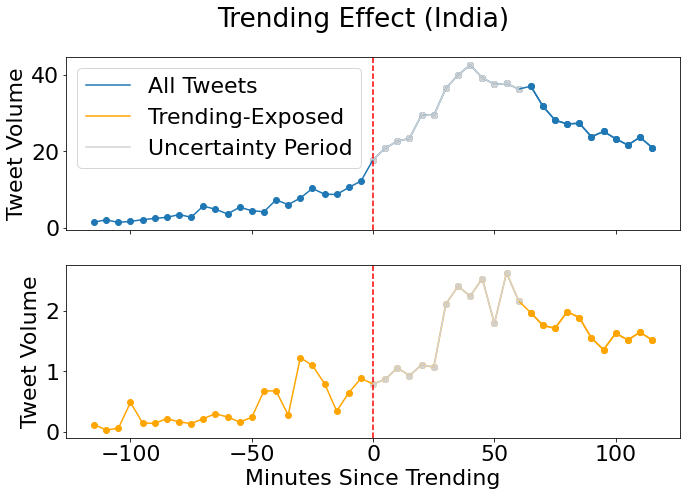

In [102]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
FIG_DIR = '/home/jschless/paper_figs'

fig, ax = plt.subplots(nrows=2, figsize=(11,7), sharex=True)

CAT = 'all_tweets'
# # plot_event_study(top_50_panel_df.loc[top_50_panel_df.index<0], cat='zero_exposure_regular', create_donut_hole=False)
plot_event_study_2(top_50_panel_df, ax[0], cat=CAT, create_donut_hole=False)
plot_event_study_2(top_50_panel_df.loc[(top_50_panel_df.index<=60) & (top_50_panel_df.index>=0)], 
                 ax[0], cat=CAT, create_donut_hole=False, color='lightgrey')
plot_event_study_2(top_50_panel_df.loc[top_50_panel_df.index>60], 
                   ax[0], cat=CAT, create_donut_hole=False)


CAT = 'zero_exposure_regular'
plot_event_study_2(top_50_panel_df, ax[1], cat=CAT, create_donut_hole=False, color='orange')
plot_event_study_2(top_50_panel_df.loc[top_50_panel_df.index>60], ax[1], cat=CAT, create_donut_hole=False, color='orange')
plot_event_study_2(top_50_panel_df.loc[(top_50_panel_df.index<=60) & (top_50_panel_df.index>=0)], 
                 ax[1], cat=CAT, create_donut_hole=False, color='lightgrey')

# # making a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#1f77b4', label='All Tweets'),
                   Line2D([0], [0], color='orange', label='Trending-Exposed'),
                   Line2D([0], [0], color='lightgrey', label='Uncertainty Period')
]

ax[0].legend(handles=legend_elements, loc='upper left')
ax[1].set_xlabel('Minutes Since Trending')
ax[0].set_ylabel("Tweet Volume")
ax[1].set_ylabel("Tweet Volume")
ax[0].axvline(x=0, c='r', ls='--')
ax[1].axvline(x=0, c='r', ls='--')
fig.suptitle('Trending Effect (India)')
plt.savefig(os.path.join(FIG_DIR, 'india_event_study_donut_hole_3.pdf'), bbox_inches="tight")

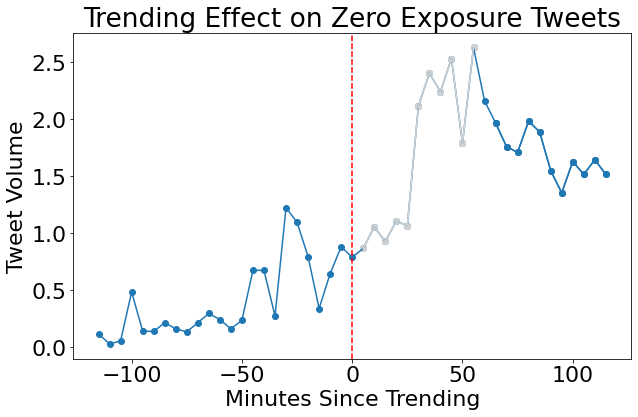

In [15]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
FIG_DIR = '/home/jschless/paper_figs'

plt.figure(figsize=(10,6))
# plot_event_study(top_50_panel_df.loc[top_50_panel_df.index<0], cat='zero_exposure_regular', create_donut_hole=False)
plot_event_study(top_50_panel_df, cat='zero_exposure_regular', create_donut_hole=False)
plot_event_study(top_50_panel_df.loc[(top_50_panel_df.index<60) & (top_50_panel_df.index>0)], 
                 cat='zero_exposure_regular', create_donut_hole=False, color='lightgrey')
plot_event_study(top_50_panel_df.loc[top_50_panel_df.index>60], cat='zero_exposure_regular', create_donut_hole=False)


plt.title('Trending Effect on Trending-Exposed Tweets')
plt.xlabel('Minutes Since Trending')
plt.axvline(x=0, c='r', ls='--')
plt.savefig(os.path.join(FIG_DIR, 'india_event_study_donut_hole.pdf'), bbox_inches="tight")

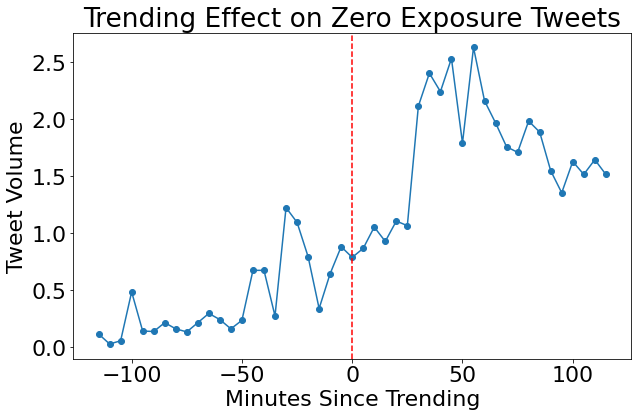

In [13]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
FIG_DIR = '/home/jschless/paper_figs'

plt.figure(figsize=(10,6))
plot_event_study(top_50_panel_df, cat='zero_exposure_regular')
plt.title('Trending Effect on Zero Exposure Tweets')
plt.xlabel('Minutes Since Trending')
plt.axvline(x=0, c='r', ls='--')
plt.savefig(os.path.join(FIG_DIR, 'india_event_study.pdf'), bbox_inches="tight")

In [16]:
def run_models(panel_df, donut_hole=False):
    # returns model results and model names for a given panel

    query = panel_df.query('time >= -120 & time <= 120').fillna(0)
    query['trend'] = pd.Categorical(query.hashtag).codes
    query = query.dropna()
    
    if donut_hole:
        print('Running with donut hole')
        query = query.query('time <= 0 | time >= 60')
    query['tweet'] = query['zero_exposure_regular'] + query['nonzero_exposure_regular']
    query['exposed_tweets'] = query['nonzero_exposure_regular']

    formula_string = "zero_exposure_tweets ~ time*threshold"
    formula_string = "adj_tweet ~ time*threshold + exposed_tweets"
#    formula_string = "adj_tweet ~ time*threshold"
    
    query['adj_tweet'] = query.tweet+1
    query['ln_tweet'] = np.log(query.tweet + 1)
    query['ln_adj_tweet'] = np.log(query.tweet + 1)
    query['ln_zero_exposure_tweets'] = np.log(query.zero_exposure_regular + 1)
#     print(query.head())
    
    plot_event_study(query, cat='zero_exposure_regular')
    plt.show()
    ols = smf.ols(formula_string, data=query).fit(
        cov_type='cluster', cov_kwds={'groups': query['trend']})


    re_ln = smf.mixedlm('ln_' + formula_string, data=query, groups=query['trend']).fit()#cov_type="HC3")
#         cov_type='cluster', cov_kwds={'groups': query['trend']})

    pois = poisson(formula_string, data=query).fit(cov_type='cluster', cov_kwds={'groups': query['trend']})
    formula_string += "+ C(trend)"
    pois_fe = poisson(formula_string, data=query).fit(cov_type='cluster', cov_kwds={'groups': query['trend']})

#     results = [re_ln, pois, pois_fe]
#     result_labels = ['Random Effects (logged outcome)', 'Poisson', 'Poisson w/ FE']
    results = [pois, pois_fe]
    result_labels = ['Poisson', 'Poisson w/ FE']
    return results, result_labels


Running with donut hole


<ipython-input-16-48a657aabc7e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query['tweet'] = query['zero_exposure_regular'] + query['nonzero_exposure_regular']
<ipython-input-16-48a657aabc7e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query['exposed_tweets'] = query['nonzero_exposure_regular']
<ipython-input-16-48a657aabc7e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

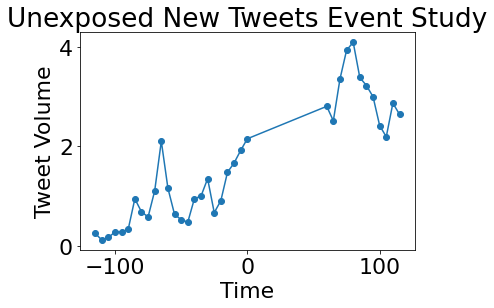

Optimization terminated successfully.
         Current function value: 5.908023
         Iterations 11
Optimization terminated successfully.
         Current function value: 3.996302
         Iterations 11
Running with donut hole


<ipython-input-16-48a657aabc7e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query['tweet'] = query['zero_exposure_regular'] + query['nonzero_exposure_regular']
<ipython-input-16-48a657aabc7e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query['exposed_tweets'] = query['nonzero_exposure_regular']
<ipython-input-16-48a657aabc7e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

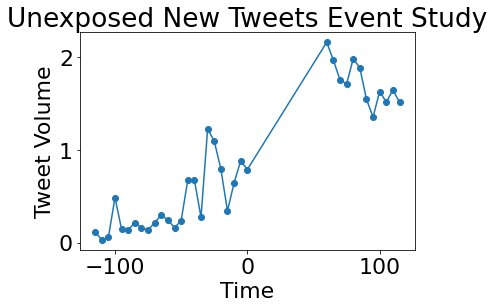

Optimization terminated successfully.
         Current function value: 3.896480
         Iterations 16
Optimization terminated successfully.
         Current function value: 2.728499
         Iterations 17


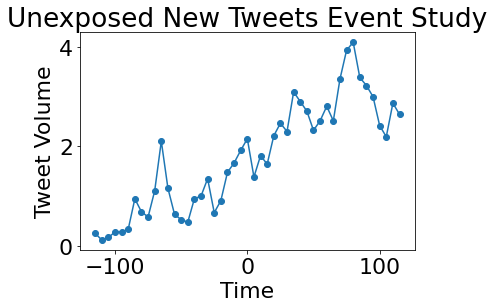

Optimization terminated successfully.
         Current function value: 6.206575
         Iterations 12
Optimization terminated successfully.
         Current function value: 4.277409
         Iterations 12


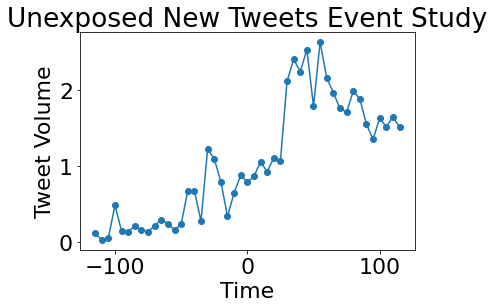

Optimization terminated successfully.
         Current function value: 4.008020
         Iterations 14
Optimization terminated successfully.
         Current function value: 2.940810
         Iterations 14


In [17]:
results_donut = [run_models(df, donut_hole=True) for df in [top_10_panel_df, top_50_panel_df]]
results = [run_models(df, donut_hole=False) for df in [top_10_panel_df, top_50_panel_df]]

In [20]:
def display_model_results(results, result_labels):
    # prints summary statistics and coefficient plot for a set of results
    for r, rl in zip(results, result_labels):
        print(rl, r.summary())
    var = 'threshold'
    coef_df = pd.DataFrame({'coef': [m.params[var] for m in results],
                            'err': [m.params[var] - m.conf_int().loc[var][0] for m in results],
                            'mod_name': result_labels
                           })
    
    return coef_df

In [21]:
coef_dfs = [display_model_results(res, mod_names) for res, mod_names in results]
coef_dfs_donut = [display_model_results(res, mod_names) for res, mod_names in results_donut]

Poisson                           Poisson Regression Results                          
Dep. Variable:              adj_tweet   No. Observations:                 1217
Model:                        Poisson   Df Residuals:                     1212
Method:                           MLE   Df Model:                            4
Date:                Tue, 11 Jan 2022   Pseudo R-squ.:                  0.6162
Time:                        17:11:02   Log-Likelihood:                -7553.4
converged:                       True   LL-Null:                       -19683.
Covariance Type:              cluster   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5089      0.194     12.944      0.000       2.129       2.889
time               0.0082      0.004      2.213      0.027       0.001       0.015
threshold         -0.0661   

## Output Table

In [34]:
results[0][1] + results[1][1] + results_donut[0][1] + results_donut[1][1]

['Poisson',
 'Poisson w/ FE',
 'Poisson',
 'Poisson w/ FE',
 'Poisson',
 'Poisson w/ FE',
 'Poisson',
 'Poisson w/ FE']

In [53]:
from stargazer.stargazer import Stargazer
models = results[0][0] + results[1][0] + results_donut[0][0] + results_donut[1][0]
tab = Stargazer(models)
tab.covariate_order(['Intercept', 'exposed_tweets', 'threshold', 'time', 'time:threshold'])
tab.rename_covariates({'exposed_tweets': 'Exposed Tweets', 'time': 'Time', 
                       'time:threshold': 'Time * Trending', 'threshold': 'Trending'})

tab.custom_columns(['Earliest / Top 10', ' Earliest / Top 10', 
                    'Earliest / Top 50', 'Earliest / Top 50', 
                   'Donut / Top 10', ' Donut / Top 10', 
                    'Donut / Top 50', 'Donut / Top 50'], [1, 1, 1,1 ,1,1,1,1])

tab.title('India Trending Effect Models')
tab.add_line('Fixed Effects', ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'])
tab.show_model_numbers(False)
tab.add_custom_notes(['Standard errors clustered at hashtag level'])

# # work around to get pseudo r2

for tm, m in zip(tab.model_data, models):
    tm['r2'] = m._results.prsquared

print([m._results.prsquared for m in models])
print(len(tab.model_data))
# tab.model_data['r2'] =  [m._results.prsquared for m in models]
tab.show_r2=True
tab.show_adj_r2=False

tab.show_residual_std_err=False
tab.show_f_statistic=False
tab.dependent_variable="Tweet Volume"


with open(os.path.join(FIG_DIR, 'india_regression_table.tex'), 'w') as f:
     print(tab.render_latex(), file=f)
print(tab.render_latex())
tab

[0.6162479929770164, 0.7355281465519099, 0.578244110895094, 0.6905444208365021, 0.6287153055254802, 0.7488558246430803, 0.569328296289727, 0.6984233798840436]
8
\begin{table}[!htbp] \centering
  \caption{India Trending Effect Models}
\begin{tabular}{@{\extracolsep{5pt}}lcccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{8}{c}{\textit{Dependent variable:}} \
\cr \cline{8-9}
\\[-1.8ex] & \multicolumn{1}{c}{Earliest / Top 10} & \multicolumn{1}{c}{ Earliest / Top 10} & \multicolumn{1}{c}{Earliest / Top 50} & \multicolumn{1}{c}{Earliest / Top 50} & \multicolumn{1}{c}{Donut / Top 10} & \multicolumn{1}{c}{ Donut / Top 10} & \multicolumn{1}{c}{Donut / Top 50} & \multicolumn{1}{c}{Donut / Top 50}  \\
\hline \\[-1.8ex]
 Intercept & 2.509$^{***}$ & 1.424$^{***}$ & 1.567$^{***}$ & 1.282$^{***}$ & 2.419$^{***}$ & 1.403$^{***}$ & 1.569$^{***}$ & 1.406$^{***}$ \\
  & (0.194) & (0.121) & (0.206) & (0.155) & (0.176) & (0.131) & (0.206) & (0.144) \\
 Exposed Tweets & 0.018$^{***}$ & 0.016$^{***

In [75]:
def plot_coefficients(coef_dfs, names=['Top 10', 'Top 50'], raw=True,
                     title="Return to Trending Estimates (Turkey)"):
    # raw: if true, show actual coefficients. if false convert to % increase
    fig, ax = plt.subplots(figsize=(8, 5))
    

    n_trials = len(coef_dfs)
    n_models = len(coef_dfs[0])
    xtick_locs = [x + (n_models-1)*.1/2 for x in range(len(coef_dfs[0]))]
    
    for i, coef, name in zip(range(n_models), coef_dfs, names):
        coef_df = coef.copy()
        coef_df['x'] = range(len(coef_df)) 
        coef_df.x += .1*i
        if not raw:
            coef_df['coef'] = coef_df['coef'].apply(lambda x: (math.exp(x) * 100) - 100)
            coef_df['err'] = coef_df['err'].apply(lambda x: (math.exp(x) * 100) - 100)
        plt.errorbar(coef_df['x'], coef_df['coef'], yerr=coef_df['err'],
                    label=name, fmt='o')
        
    
    plt.legend(title="Trending Threshold", loc=4)
    ax.set_ylabel('')
    ax.set_xlabel('')
    # ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.set_title('Return to Trending Estimates')
    print(xtick_locs, n_models)
    ax.xaxis.set_ticks(xtick_locs)
    ax.xaxis.set_ticklabels(coef_df['mod_name'].tolist())
    ax.xaxis.set_label_text('Model Type')
    if raw:
        ax.yaxis.set_label_text('Coefficient Value')
    else:
        ax.yaxis.set_label_text('% Increase in Tweet Volume')
        
    return fig, ax

[0.05, 1.05] 2


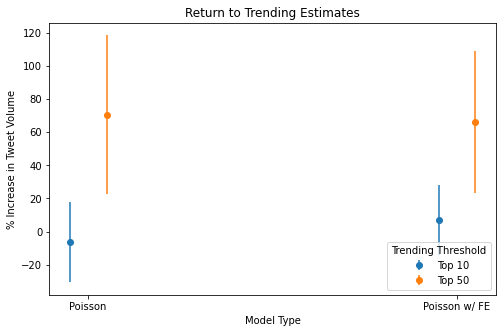

In [76]:
fig, ax = plot_coefficients(coef_dfs.copy(), raw=False)

In [71]:
fig.savefig(os.path.join(DATA_DIR, 'india_effect_sizes_donut_hole.pdf'))

In [78]:
fig.savefig(os.path.join(DATA_DIR, 'india_effect_sizes.pdf'))
os.path.join(DATA_DIR, 'india_effect_sizes.pdf')

'/pool001/jschless/kiran-data/kiran-data/india_effect_sizes.pdf'

### Creating a Dict to Export the Models
I want to combine all coefficients

In [63]:
coef_dfs[0]['kind'] = 'earliest'
coef_dfs[0]['cat'] = 'top_10'
coef_dfs[1]['kind'] = 'earliest'
coef_dfs[1]['cat'] = 'top_50'
coef_dfs_donut[0]['kind'] = 'donut'
coef_dfs_donut[0]['cat'] = 'top_10'
coef_dfs_donut[1]['kind'] = 'donut'
coef_dfs_donut[1]['cat'] = 'top_50'
pd.concat([*coef_dfs, *coef_dfs_donut]).reset_index().drop(columns='index').to_dict()

{'coef': {0: -0.06610466080296476,
  1: 0.06849799459444841,
  2: 0.5335331625553397,
  3: 0.5061122454371987,
  4: -0.09464360766212288,
  5: 0.04517155707073757,
  6: 0.5200828292267733,
  7: 0.5239028533403469},
 'err': {0: 0.21713832128976837,
  1: 0.19253585369794615,
  2: 0.3913600809799527,
  3: 0.3566169104115723,
  4: 0.3140877019332967,
  5: 0.3129431098274066,
  6: 0.5489509021289611,
  7: 0.6109279426993857},
 'mod_name': {0: 'Poisson',
  1: 'Poisson w/ FE',
  2: 'Poisson',
  3: 'Poisson w/ FE',
  4: 'Poisson',
  5: 'Poisson w/ FE',
  6: 'Poisson',
  7: 'Poisson w/ FE'},
 'kind': {0: 'earliest',
  1: 'earliest',
  2: 'earliest',
  3: 'earliest',
  4: 'donut',
  5: 'donut',
  6: 'donut',
  7: 'donut'},
 'cat': {0: 'top_10',
  1: 'top_10',
  2: 'top_50',
  3: 'top_50',
  4: 'top_10',
  5: 'top_10',
  6: 'top_50',
  7: 'top_50'}}

In [62]:
pd.DataFrame.from_dict(pd.concat([*coef_dfs, *coef_dfs_donut]).reset_index().drop(columns='index').to_dict())

,coef,err,mod_name,kind,cat
0,-0.066105,0.217138,Poisson,earliest,top_10
1,0.068498,0.192536,Poisson w/ FE,earliest,top_10
2,0.533533,0.391360,Poisson,earliest,top_50
3,0.506112,0.356617,Poisson w/ FE,earliest,top_50
4,-0.094644,0.314088,Poisson,donut,top_10
5,0.045172,0.312943,Poisson w/ FE,donut,top_10
6,0.520083,0.548951,Poisson,donut,top_50
7,0.523903,0.610928,Poisson w/ FE,donut,top_50


In [44]:
res = {'donut': {}, 'earliest': {}}

In [45]:
res['donut']['top_10'] = coef_dfs_donut[0].to_dict()
res['donut']['top_50'] = coef_dfs_donut[1].to_dict()

In [47]:
res['earliest']['top_10'] = coef_dfs[0].to_dict()
res['earliest']['top_50'] = coef_dfs[1].to_dict()

In [49]:
coef_dfs[0].to_dict()

,coef,err,mod_name
0,-0.066105,0.217138,Poisson
1,0.068498,0.192536,Poisson w/ FE


In [51]:
from pprint import pprint
pprint(res)

{'donut': {'top_10': {'coef': {0: -0.09464360766212288, 1: 0.04517155707073757},
                      'err': {0: 0.3140877019332967, 1: 0.3129431098274066},
                      'mod_name': {0: 'Poisson', 1: 'Poisson w/ FE'}},
           'top_50': {'coef': {0: 0.5200828292267733, 1: 0.5239028533403469},
                      'err': {0: 0.5489509021289611, 1: 0.6109279426993857},
                      'mod_name': {0: 'Poisson', 1: 'Poisson w/ FE'}}},
 'earliest': {'top_10': {'coef': {0: -0.06610466080296476,
                                  1: 0.06849799459444841},
                         'err': {0: 0.21713832128976837,
                                 1: 0.19253585369794615},
                         'mod_name': {0: 'Poisson', 1: 'Poisson w/ FE'}},
              'top_50': {'coef': {0: 0.5335331625553397, 1: 0.5061122454371987},
                         'err': {0: 0.3913600809799527, 1: 0.3566169104115723},
                         'mod_name': {0: 'Poisson', 1: 'Poisson w/ FE'}}}}
